# Applied Data Science Capstone (Coursera)

*This notebook for the assignment specified in Weeks 4 and 5*

The aim of this assignment is to explore, segment, and cluster the neighborhoods in the city of **Toronto, Ontario, Canada**. However, unlike New York, the neighborhood data is not readily available on the internet. For the Toronto neighborhood data, a Wikipedia [page](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M) exists that has all the information we need to explore and cluster the neighborhoods in Toronto. 

---

## Part 1: Obtain the data from the Wikipedia page and create a working dataframe.

The first thing to do is to scrape the Wikipedia page and wrangle the data, clean it, and then read it into a pandas  dataframe so that it is in a structured format like the New York City dataset. The link to the Wikipedia page is https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M.

The following libraries shown in the code cell below is required for this project. Please ensure that you have these libraries installed beforehand before running the next code. The website for [PyPI, the Python Package Index](https://pypi.org/) provides instructions on how to install these libraries.

Import the required libraries for the project:

In [3]:
from bs4 import BeautifulSoup
import requests
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import folium
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline 
from sklearn.cluster import KMeans 
from kneed import KneeLocator
from geopy.geocoders import Nominatim 

print('All libraries have been imported.')

All libraries have been imported.


The **requests library** is used to collect data from the assigned webpage, as specified by the ```URL``` variable in the cell below. The ```request.get()``` method was used to obtain the data from the webpage and the result assigned to the ```response``` variable. 

In [4]:
URL = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
response = requests.get(URL)

In the cell below, the ```status_code``` attribute of the ```response``` variable was called to check if the webpage was downloaded successfully. The returned code of ```200``` shows that the webpage downloaded successfully. 

In [5]:
response.status_code

200

Next, using Python’s built-in ```html.parser```, the ```response.text``` document was parsed to obtain a nested data structure. This is assigned to the variable ```soup```.

In [6]:
soup = BeautifulSoup(response.text, 'html.parser')

To check that the correct webpage was scraped, the ```title``` attribute of the ```soup```variable was called.

In [7]:
print(soup.title)

<title>List of postal codes of Canada: M - Wikipedia</title>


The data needed to create the dataframe is within a table with 3 columns, 'Postal Code', 'Borough' and 'Neighbourhood'. On the Wikipedia [page](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M), HTML elements for each item can be viewed by inspecting the source. This can be done by hitting the buttons ```CTRL``` + ```SHIFT``` + ```I```, which opens the ```Developer Tools``` pane. Viewing the contents of the webpage and the  ```Developer Tools``` pane side by side makes it easier to read the HTML. Within the pane, the elements can be expanded and collapsed as desired to view the contents by clicking on the little gray riangular button. When the mouse cursor hovers over and scrolls down the list of HTML elements in the ```Developer Tools``` pane, the webpage's contents will be highlighted, which makes it easier to identify the block of HTML elements corresponding table. The elements identifying the table are: ```<table class="wikitable sortable jquery-tablesorter">```.

The ```find``` method is then used to obtain the table using the attributes specified by the ```class``` and the result assigned to the ```table``` variable.

In [8]:
table = soup.find("table", attrs={"class": "wikitable"})

The ```<tr>``` tag defines a table row. The ```find_all()``` method is used to idenfity and extract all rows using the string, "tr", from the table body (defined by the attribute, ```tbody```). The result is passed to the ```rows``` variable and the ```len``` function used to count the number of rows in the table.

In [9]:
rows = table.tbody.find_all("tr")

In [10]:
print('The number of rows found in the table is', len(rows))

The number of rows found in the table is 181


The following code shows the contents of the first item in the ```rows``` variable.

In [11]:
print(rows[0])

<tr>
<th>Postal Code
</th>
<th>Borough
</th>
<th>Neighbourhood
</th></tr>


The HTML tags need to be removed before creating the dataframe. A new variable called ```table_data``` is initialized and a ```for``` loop used to append each row after the HTML tags have been stripped and replaced by a tab ('\t').

In [12]:
table_data = []
for row in rows:
    table_data.append(row.text.replace('\n', '\t').strip())

A new dataframe called ```df``` was then made using **pandas**, as shown in the code below. The first 5 lines of the dataframe can be called using the ```.head()``` method.

In [13]:
df = pd.DataFrame(table_data, columns=['col1'])
df.head()

,col1
0,Postal Code\t\tBorough\t\tNeighbourhood
1,M1A\t\tNot assigned\t\tNot assigned
2,M2A\t\tNot assigned\t\tNot assigned
3,M3A\t\tNorth York\t\tParkwoods
4,M4A\t\tNorth York\t\tVictoria Village


The following cells contain codes to get the dataframe, ```df``` in the right format before it's used for any data wrangling or cleaning steps. A new dataframe is created with each substantial formatting step, to avoid having to re-make the original dataframe again if there was a mistake. Doing this also helps to keep track of the changes made to the original dataframe.

The contents of each row needs to be split using the tab delimiter, '\t'. A new dataframe, ```df1``` is created after the split.

In [14]:
df1 = df.col1.str.split('\t\t', expand=True)
df1

,0,1,2
0,Postal Code,Borough,Neighbourhood
1,M1A,Not assigned,Not assigned
2,M2A,Not assigned,Not assigned
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
...,...,...,...
176,M5Z,Not assigned,Not assigned
177,M6Z,Not assigned,Not assigned
178,M7Z,Not assigned,Not assigned
179,M8Z,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,..."


The contents of the first row is the header for each column. The following code extracts that information, passing it to a list called ```header```.

In [15]:
header = df1.iloc[0]
header

0      Postal Code
1          Borough
2    Neighbourhood
Name: 0, dtype: object

A new dataframe, ```df2```, was created by extracting the rows from the second row onwards from ```df1```.

In [16]:
df2 = df1[1:]
df2

,0,1,2
1,M1A,Not assigned,Not assigned
2,M2A,Not assigned,Not assigned
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,"Regent Park, Harbourfront"
...,...,...,...
176,M5Z,Not assigned,Not assigned
177,M6Z,Not assigned,Not assigned
178,M7Z,Not assigned,Not assigned
179,M8Z,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,..."


The ```header``` list is then used to name the columns in ```df2```.

In [17]:
df2.columns = header
df2

,Postal Code,Borough,Neighbourhood
1,M1A,Not assigned,Not assigned
2,M2A,Not assigned,Not assigned
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,"Regent Park, Harbourfront"
...,...,...,...
176,M5Z,Not assigned,Not assigned
177,M6Z,Not assigned,Not assigned
178,M7Z,Not assigned,Not assigned
179,M8Z,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,..."


The index of ```df2``` was then reset, as shown below.

In [18]:
df2.reset_index(inplace=True)

In [19]:
df2

,index,Postal Code,Borough,Neighbourhood
0,1,M1A,Not assigned,Not assigned
1,2,M2A,Not assigned,Not assigned
2,3,M3A,North York,Parkwoods
3,4,M4A,North York,Victoria Village
4,5,M5A,Downtown Toronto,"Regent Park, Harbourfront"
...,...,...,...,...
175,176,M5Z,Not assigned,Not assigned
176,177,M6Z,Not assigned,Not assigned
177,178,M7Z,Not assigned,Not assigned
178,179,M8Z,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,..."


After the index has been reset, a new column containing the previous index values was created ('index'). This column was then deleted using the ```.drop()``` method and the remaining columns passed to a new dataframe, ```df3```.

In [20]:
df3 = df2.drop('index', axis=1)

In [21]:
df3

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
...,...,...,...
175,M5Z,Not assigned,Not assigned
176,M6Z,Not assigned,Not assigned
177,M7Z,Not assigned,Not assigned
178,M8Z,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,..."


Now the dataframe is ready to be wrangled or cleaned as per the instructions set out in the assignment. Before starting, a new dataframe, ```df4``` was cloned from the correctly formatted dataframe, ```df3```.

In [22]:
df4 = df3[:]
df4.columns

Index(['Postal Code', 'Borough', 'Neighbourhood'], dtype='object', name=0)

The following code shows the data types found in each column of the dataframe.

In [23]:
df4.dtypes

0
Postal Code      object
Borough          object
Neighbourhood    object
dtype: object

The step was to only process the cells that have an assigned borough and ignore cells with a borough that is 'Not assigned'. The following code tests whether the column 'Borough' has the string, 'Not assigned' and returns a Boolean result for each row.

In [24]:
df4['Borough'] == 'Not assigned'

0       True
1       True
2      False
3      False
4      False
       ...  
175     True
176     True
177     True
178    False
179     True
Name: Borough, Length: 180, dtype: bool

Cells with the string 'Not assigned' in the column 'Borough' were dropped from the dataframe. The option ```inplace = True``` signifies that the dataframe is to be overwritten when the changes are made. The resulting dataframe is then checked to view the changes made.

In [25]:
df4.drop(df4[df4['Borough'] == 'Not assigned'].index, inplace = True) 

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [26]:
df4

,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...,...
160,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
165,M4Y,Downtown Toronto,Church and Wellesley
168,M7Y,East Toronto,"Business reply mail Processing Centre, South C..."
169,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


Another way to check if there are any cells with the string 'Not assigned' in the column 'Borough' is to use the ```.any()``` method. The resulting Boolean value, ```False```, shows that there is no cell with that string in the column.

In [27]:
(df4['Borough'] == 'Not assigned').any()

False

If a cell has a borough but a 'Not assigned'  neighborhood, then the neighborhood will be the same as the borough. As asbove, the ```.any()``` method was used on the column 'Neighbourhood' to check for the string. The resulting Boolean value, ```False```, shows that there was none.

In [28]:
(df4['Neighbourhood'] == 'Not assigned').any()

False

The next step was to check if a postal code is shared by more than one neighbourhood. Taking another look at the df4 using the code below didn't help much as the entire dataframe couldn't be seen. However, the sentence below the dataframe shows that it has 103 rows and 3 columns.

In [29]:
df4

,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...,...
160,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
165,M4Y,Downtown Toronto,Church and Wellesley
168,M7Y,East Toronto,"Business reply mail Processing Centre, South C..."
169,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


The ```.groupby()``` method is used in the following code to group the data by values specified in the 'Postal Code'. The ```.agg()``` method is used to aggregate the data sharing the same string in the column 'Postal Code', joining the values in the column 'Neighbourhood' using a comma. The result was assigned to a new dataframe, ```df5```.

In [30]:
df5 = df4.groupby('Postal Code').agg(lambda x: ','.join(x))
df5

,Borough,Neighbourhood
Postal Code,,
M1B,Scarborough,"Malvern, Rouge"
M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
M1E,Scarborough,"Guildwood, Morningside, West Hill"
M1G,Scarborough,Woburn
M1H,Scarborough,Cedarbrae
...,...,...
M9N,York,Weston
M9P,Etobicoke,Westmount
M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ..."


The new dataframe does not have a proper index. So the ```.reset_index(inplace=True)``` method was used to reset the index and overwrite the data in the dataframe. A quick check of the dataframe shows that it now has the proper indexing and 3 columns - 'Postal Code, 'Borough' and 'Neighborhood'.

In [31]:
df5.reset_index(inplace=True)

In [32]:
df5

,Postal Code,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
...,...,...,...
98,M9N,York,Weston
99,M9P,Etobicoke,Westmount
100,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ..."
101,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest..."


The ```.nunique()``` method can be used to check the there are any unique values in the column 'Postal Code' and to return a result showing the count of unique values.

In [33]:
df5['Postal Code'].nunique()

103

In the last cell of this part, the ```.shape``` method is used to print the number of rows of the cleaned dataframe.

In [34]:
print('The data frame has', df5.shape[0], 'rows')

The data frame has 103 rows


--- 

## Part 2: Get the latitude and the longitude coordinates of each neighborhood.

In order to utilize the Foursquare location data, the latitude and the longitude coordinates of each neighborhood must be obtained and appended to the cleaned dataframe as two separate columns called 'Latitude' and 'Longitude'.

A comma-separated values (CSV) file containing the latitude and longtitude for each postal code has been provided (Geospatial_Coordinates.csv). The following code reads the file into a new dataframe calle ```latlng```.

In [36]:
latlng = pd.read_csv('Geospatial_Coordinates.csv')

In [37]:
latlng.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


As dataframe merge needs to be conducted to add the coordinates for each postal code specified in ```df5```, the data type of the ```latlng``` dataframe was checked. The values in the column 'Postal Code' in both dataframes are of the same type - ```object```.

In [38]:
latlng.dtypes

Postal Code     object
Latitude       float64
Longitude      float64
dtype: object

The following code using the ```.merge``` method to join both dataframes together based on the common values found in the column 'Postal Code' in both dataframes.

In [39]:
df6 = pd.merge(df5, latlng, on=['Postal Code'])
df6.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


This is to check that the resulting dataframe has the same number of rows as previously but with two new columns added.

In [40]:
print('The current data frame has', df6.shape[0], 'rows and', df6.shape[1], 'columns')

The current data frame has 103 rows and 5 columns


--- 

## Part 3: Explore and cluster the neighborhoods in Toronto. 

This part involves working with boroughs that contain the word 'Toronto' and then replicate the same analysis done with the New York City data in the labs.

Renamed the dataframe created in Part 2 as ```neighborhoods```.

In [41]:
neighborhoods = df6[:]
neighborhoods.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


The following code uses the **geopy library** to obtain the coordinates of Toronto in Ontario, Canada. In order to define an instance of the geocoder, a user_agent called <em>toronto_explorer</em> was created, as shown below.

In [42]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


The following code creates a map of Toronto using the **folium library**

In [43]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

There are 4 boroughs with the word 'Toronto' in their names - Downtown Toronto, Central Toronto, East Toronto and West Toronto. 

In [44]:
city_data = neighborhoods[neighborhoods['Borough'].isin(['Downtown Toronto', 'Central Toronto', 'East Toronto', 'West Toronto'])].reset_index(drop=True)
city_data.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


In [45]:
print('The dataframe for all boroughs with the word `Toronto` has', city_data.shape[0], 'rows')

The dataframe for all boroughs with the word `Toronto` has 39 rows


In [46]:
city = 'Toronto, ON'
boroughs = ['Downtown Toronto', 'Central Toronto', 'East Toronto', 'West Toronto']

for borough in boroughs:
    address = borough + ', ' + city
    geolocator = Nominatim(user_agent="toronto_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    print('The geographical coordinate of ', borough, 'are {}, {}.'.format(latitude, longitude))

The geographical coordinate of  Downtown Toronto are 43.6563221, -79.3809161.
The geographical coordinate of  Central Toronto are 43.65238435, -79.38356765.
The geographical coordinate of  East Toronto are 43.626243, -79.396962.
The geographical coordinate of  West Toronto are 43.65238435, -79.38356765.


In [47]:
map_city = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(city_data['Latitude'], city_data['Longitude'], city_data['Borough'], city_data['Neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_city)  
    
map_city

The Foursquare API was used to to explore these neighborhoods and segment them.

In [1]:
CLIENT_ID = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx' 
CLIENT_SECRET = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx' 
ACCESS_TOKEN = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx' 
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
CLIENT_SECRET:xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx


In [49]:
city_data.loc[0, 'Neighbourhood']

'The Beaches'

In [50]:
neighborhood_latitude = city_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = city_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = city_data.loc[0, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of The Beaches are 43.67635739999999, -79.2930312.


The following code gets the top 100 venues that are in The Beaches within a radius of 500 meters.

In [51]:
LIMIT = 100 
radius = 500

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx&client_secret=xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx&v=20180605&ll=43.67635739999999,-79.2930312&radius=500&limit=100'

A GET request was sent to obtain the desired information, which was then passed to a variable called ```results```. 

In [351]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ffe445611c51b2f0dcd9f46'},
 'response': {'headerLocation': 'The Beaches',
  'headerFullLocation': 'The Beaches, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 4,
  'suggestedBounds': {'ne': {'lat': 43.680857404499996,
    'lng': -79.28682091449052},
   'sw': {'lat': 43.67185739549999, 'lng': -79.29924148550948}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bd461bc77b29c74a07d9282',
       'name': 'Glen Manor Ravine',
       'location': {'address': 'Glen Manor',
        'crossStreet': 'Queen St.',
        'lat': 43.67682094413784,
        'lng': -79.29394208780985,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.67682094413784,
          'lng': -79.29394208780985}],
        'distanc

All the information that is needed can be found in the _items_ key. The **get_category_type** function is used to extract the category of the venues found.

In [352]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

The following code obtains the required information about the venues and structure that information into a _pandas_ dataframe.

In [353]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Glen Manor Ravine,Trail,43.676821,-79.293942
1,The Big Carrot Natural Food Market,Health Food Store,43.678879,-79.297734
2,Grover Pub and Grub,Pub,43.679181,-79.297215
3,Upper Beaches,Neighborhood,43.680563,-79.292869


The following shows the number of venues returned by the Foursquare API.

In [354]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

4 venues were returned by Foursquare.


The following function repeat the same process used on The Beaches to all the neighborhoods in the four Toronto boroughs.

In [355]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Running the ```getNearbyVenues``` prints out a list of all neighbourhoods found in the boroughs of Downtown Toronto, Central Toronto, East Toronto and West Toronto.

In [356]:
city_venues = getNearbyVenues(names=city_data['Neighbourhood'], latitudes=city_data['Latitude'], longitudes=city_data['Longitude'])

The Beaches
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Lawrence Park
Davisville North
North Toronto West,  Lawrence Park
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North & West, Forest Hill Road Park
The Annex, North Midtown, Yorkville
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Stn A PO Boxes
First Canadian Place, Underground city
Christie
Dufferin, Dovercourt Village
Little Portugal, Trinity
Brockton, Parkdale Village, Exhibition Place
High

The following code cell shows that the new ```city_venues``` dataframe shows the number of rows and columns, while the ```.head()``` shows the first 5 rows.

In [357]:
print(city_venues.shape)
city_venues.head()

(1615, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,"The Danforth West, Riverdale",43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant


The number of venues returned for each neighbourhood is as shown below:

In [358]:
city_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Berczy Park,58,58,58,58,58,58
"Brockton, Parkdale Village, Exhibition Place",22,22,22,22,22,22
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",16,16,16,16,16,16
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",15,15,15,15,15,15
Central Bay Street,60,60,60,60,60,60
Christie,15,15,15,15,15,15
Church and Wellesley,79,79,79,79,79,79
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,33,33,33,33,33,33


The following cell shows the code to obtain the number of unique categories found.

In [359]:
print('There are {} uniques categories.'.format(len(city_venues['Venue Category'].unique())))

There are 235 uniques categories.


In order to segment and cluster the neighborhoods on a map of Toronto showing the four boroughs, the categorical values in the ```city_venues``` dataframe needs to be converted to numerical values using one-hot encoding. A new dataframe called ```city_onehot``` is created. 

In [360]:
city_onehot = pd.get_dummies(city_venues[['Venue Category']], prefix="", prefix_sep="")

city_onehot['Neighbourhood'] = city_venues['Neighbourhood'] 

fixed_columns = [city_onehot.columns[-1]] + list(city_onehot.columns[:-1])
city_onehot = city_onehot[fixed_columns]

city_onehot.head()

,Neighbourhood,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"The Danforth West, Riverdale",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [361]:
print('The new city_onehot dataframe has', city_onehot.shape[0], 'rows and', city_onehot.shape[1], 'columns')

The new city_onehot dataframe has 1615 rows and 236 columns


Following one-hot encoding of the dataframe, the rows are then grouped by neighborhood. The mean of the frequency of occurrence for each category in each neighbourhood is showed using the ```.mean()```.

In [362]:
city_grouped = city_onehot.groupby('Neighbourhood').mean().reset_index()
city_grouped

,Neighbourhood,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.00,0.017241,0.00000,0.000000,0.000000,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00000,0.000000,0.000000,0.000000
2,"Business reply mail Processing Centre, South C...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00000,0.000000,0.000000,0.062500
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.066667,0.066667,0.066667,0.133333,0.066667,0.133333,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00000,0.000000,0.000000,0.000000
4,Central Bay Street,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.00,0.016667,0.00000,0.000000,0.016667,0.016667
5,Christie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00000,0.000000,0.000000,0.000000
6,Church and Wellesley,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012658,0.000000,0.00,...,0.012658,0.000000,0.000000,0.000000,0.00,0.000000,0.00000,0.012658,0.000000,0.025316
7,"Commerce Court, Victoria Hotel",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.00,0.020000,0.00000,0.000000,0.010000,0.000000
8,Davisville,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.030303,0.000000,0.00,0.000000,0.00000,0.000000,0.000000,0.000000
9,Davisville North,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00000,0.000000,0.000000,0.000000


In [363]:
print('The new city_grouped dataframe has', city_grouped.shape[0], 'rows and', city_grouped.shape[1], 'columns')

The new city_grouped dataframe has 39 rows and 236 columns


Repeating the grouping but this time, getting the total number of venues for each catergory per neighborhood.

In [364]:
city_grouped1 = city_onehot.groupby('Neighbourhood').sum().reset_index()
city_grouped1

,Neighbourhood,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,Berczy Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,"Brockton, Parkdale Village, Exhibition Place",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Business reply mail Processing Centre, South C...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,"CN Tower, King and Spadina, Railway Lands, Har...",1,1,1,2,1,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Central Bay Street,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1
5,Christie,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Church and Wellesley,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,2
7,"Commerce Court, Victoria Hotel",0,0,0,0,0,0,4,0,0,...,0,0,0,0,0,2,0,0,1,0
8,Davisville,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
9,Davisville North,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In order to solve the business problem, columns related to restaurants from the `city_grouped` dataframe need to be extracted. The results were assigned the `restaurants` dataframe.

In [365]:
restaurants = city_grouped1.loc[:,city_grouped1.columns.str.contains("Restaurant")]
restaurants.head()

,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,...,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,0,0,0,0,0,0,0,0,1,0,...,0,2,2,1,0,1,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,2,0,0,1,0


Getting a total for each type of restaurant found in these neighborhoods and creating a dataframe with the data. The new dataframe, `res_count` is re-indexed and the columns renamed to indicate its contents.

In [366]:
res_count = restaurants[restaurants != 0].count()
res_count

American Restaurant                10
Asian Restaurant                    6
Belgian Restaurant                  2
Brazilian Restaurant                2
Cajun / Creole Restaurant           1
Caribbean Restaurant                4
Chinese Restaurant                  5
Colombian Restaurant                2
Comfort Food Restaurant             6
Cuban Restaurant                    2
Doner Restaurant                    1
Eastern European Restaurant         3
Ethiopian Restaurant                2
Falafel Restaurant                  2
Fast Food Restaurant               12
Filipino Restaurant                 1
French Restaurant                  10
German Restaurant                   1
Gluten-free Restaurant              4
Greek Restaurant                    6
Indian Restaurant                   7
Italian Restaurant                 22
Japanese Restaurant                17
Korean Restaurant                   3
Latin American Restaurant           5
Mediterranean Restaurant            3
Mexican Rest

In [367]:
res_count_df = pd.DataFrame(res_count)
res_count_df.head()

,0
American Restaurant,10
Asian Restaurant,6
Belgian Restaurant,2
Brazilian Restaurant,2
Cajun / Creole Restaurant,1


In [368]:
res_count_df.reset_index(inplace=True)
res_count_df.head()

,index,0
0,American Restaurant,10
1,Asian Restaurant,6
2,Belgian Restaurant,2
3,Brazilian Restaurant,2
4,Cajun / Creole Restaurant,1


In [369]:
res_count_df.columns = ['Restaurant Type', 'Count']
res_count_df.head()

,Restaurant Type,Count
0,American Restaurant,10
1,Asian Restaurant,6
2,Belgian Restaurant,2
3,Brazilian Restaurant,2
4,Cajun / Creole Restaurant,1


The **seaborn library** is then used to plot the data as shown below

<AxesSubplot:xlabel='Count', ylabel='Restaurant Type'>

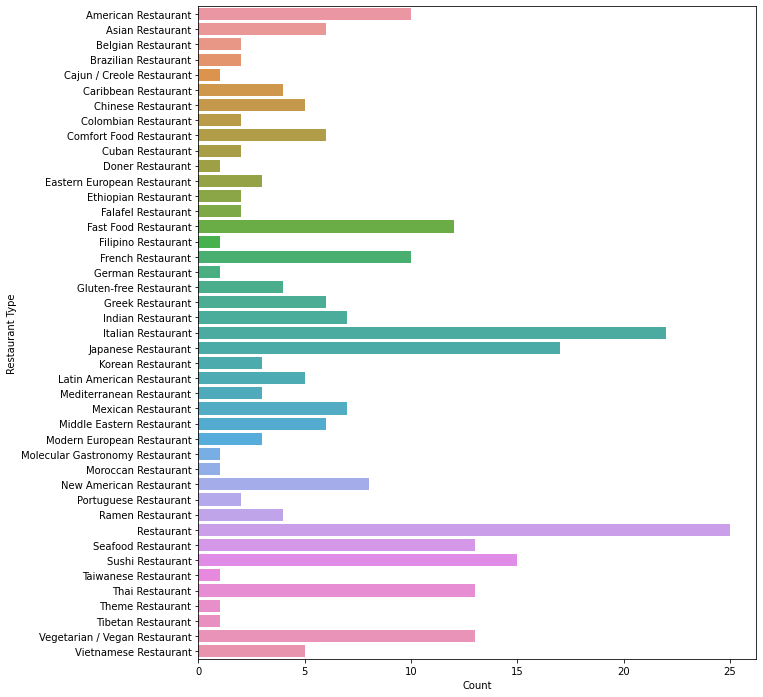

In [370]:
fig, ax = plt.subplots(figsize=(10,12))
sns.barplot(x="Count", y="Restaurant Type", data=res_count_df, ax=ax)

Collectively, the restaurants in the 39 neighbourhoods of Toronto had predominantly Italian cuisine, followed by Japanese and sushi restaurants. Note that there may be an overlap in the cuisines as shown by the different categories. Moreover, some categories (e.g. Restaurant, Theme Restaurant) do not clearly indicate their cuisine type.

The dataframe can also be transposed to show the total number of restaurants for each neighborhood. However, the 'Neighbourhood' columns need to be added back to the `restaurants` dataframe. The information was initially extracted as a list and then assigned to the dataframe. 

In [371]:
cols = city_grouped1['Neighbourhood'].tolist()
cols_df = pd.DataFrame(cols)
cols_df.head()

,0
0,Berczy Park
1,"Brockton, Parkdale Village, Exhibition Place"
2,"Business reply mail Processing Centre, South C..."
3,"CN Tower, King and Spadina, Railway Lands, Har..."
4,Central Bay Street


First the len of the `col_df` and `restaurants` were checked to ensure they are the same size. Then the column in `cols_df` was renamed 'Neighbourhood'. 

In [372]:
len(cols_df)

39

In [373]:
len(restaurants)

39

In [374]:
cols_df.columns = ['Neighbourhood']
cols_df.head()

,Neighbourhood
0,Berczy Park
1,"Brockton, Parkdale Village, Exhibition Place"
2,"Business reply mail Processing Centre, South C..."
3,"CN Tower, King and Spadina, Railway Lands, Har..."
4,Central Bay Street


A new dataframe (`res_cols`) was cloned from the `restaurants` dataframe and the 'Neighbourhood' columns from `cols_df` inserted as first column.

In [375]:
res_cols = restaurants[:]
res_cols.head()

,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,...,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,0,0,0,0,0,0,0,0,1,0,...,0,2,2,1,0,1,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,2,0,0,1,0


In [376]:
res_cols.insert(loc=0, column='Neighbourhood', value=cols)

In [377]:
res_cols.head()

,Neighbourhood,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,...,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Berczy Park,0,0,0,0,0,0,0,0,1,...,0,2,2,1,0,1,0,0,1,0
1,"Brockton, Parkdale Village, Exhibition Place",0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,"Business reply mail Processing Centre, South C...",0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,"CN Tower, King and Spadina, Railway Lands, Har...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Central Bay Street,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,2,0,0,1,0


Before transposing the dataframe, the 'Neighbourhood' column needs to be used as the index.

In [378]:
res_cols.set_index('Neighbourhood')

,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Cuban Restaurant,...,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
Neighbourhood,,,,,,,,,,,,,,,,,,,,,
Berczy Park,0,0,0,0,0,0,0,0,1,0,...,0,2,2,1,0,1,0,0,1,0
"Brockton, Parkdale Village, Exhibition Place",0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Central Bay Street,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,2,0,0,1,0
Christie,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
Church and Wellesley,1,0,0,0,0,1,0,0,0,0,...,1,3,0,5,0,1,1,0,0,1
"Commerce Court, Victoria Hotel",4,1,0,0,0,0,0,0,0,0,...,0,7,3,0,0,2,0,0,2,0
Davisville,0,0,0,0,0,0,0,0,0,0,...,0,1,1,2,0,1,0,0,0,0


In [379]:
res_cols_t = res_cols.T

In [380]:
res_cols_t.head()

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
Neighbourhood,Berczy Park,"Brockton, Parkdale Village, Exhibition Place","Business reply mail Processing Centre, South C...","CN Tower, King and Spadina, Railway Lands, Har...",Central Bay Street,Christie,Church and Wellesley,"Commerce Court, Victoria Hotel",Davisville,Davisville North,...,St. James Town,"St. James Town, Cabbagetown",Stn A PO Boxes,Studio District,"Summerhill West, Rathnelly, South Hill, Forest...","The Annex, North Midtown, Yorkville",The Beaches,"The Danforth West, Riverdale","Toronto Dominion Centre, Design Exchange","University of Toronto, Harbord"
American Restaurant,0,0,0,0,0,0,1,4,0,0,...,3,0,1,2,1,0,0,1,3,0
Asian Restaurant,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,2,0
Belgian Restaurant,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
Brazilian Restaurant,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The first row with the 'Neighbourhood' values is then used a column labels. The resulting dataframe `res_cols_t1`is then properly structured for further analysis.

In [381]:
nb_header = res_cols_t.iloc[0]
res_cols_t1 = res_cols_t[1:]
res_cols_t1.columns = nb_header

In [382]:
res_cols_t1.reset_index()
res_cols_t1.head()

Neighbourhood,Berczy Park,"Brockton, Parkdale Village, Exhibition Place","Business reply mail Processing Centre, South Central Letter Processing Plant Toronto","CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",Central Bay Street,Christie,Church and Wellesley,"Commerce Court, Victoria Hotel",Davisville,Davisville North,...,St. James Town,"St. James Town, Cabbagetown",Stn A PO Boxes,Studio District,"Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park","The Annex, North Midtown, Yorkville",The Beaches,"The Danforth West, Riverdale","Toronto Dominion Centre, Design Exchange","University of Toronto, Harbord"
American Restaurant,0,0,0,0,0,0,1,4,0,0,...,3,0,1,2,1,0,0,1,3,0
Asian Restaurant,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,2,0
Belgian Restaurant,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
Brazilian Restaurant,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Cajun / Creole Restaurant,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The above dataframe is then transponse to create another showing the total number of restaurants per neighborhood.

In [383]:
nb_total = pd.DataFrame(res_cols_t1.sum())
nb_total.reset_index(inplace=True)

In [384]:
nb_total.columns = ['Neighbourhood', 'Restaurant Count']

In [385]:
nb_total.head()

,Neighbourhood,Restaurant Count
0,Berczy Park,12.0
1,"Brockton, Parkdale Village, Exhibition Place",2.0
2,"Business reply mail Processing Centre, South C...",2.0
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.0
4,Central Bay Street,17.0


<AxesSubplot:xlabel='Restaurant Count', ylabel='Neighbourhood'>

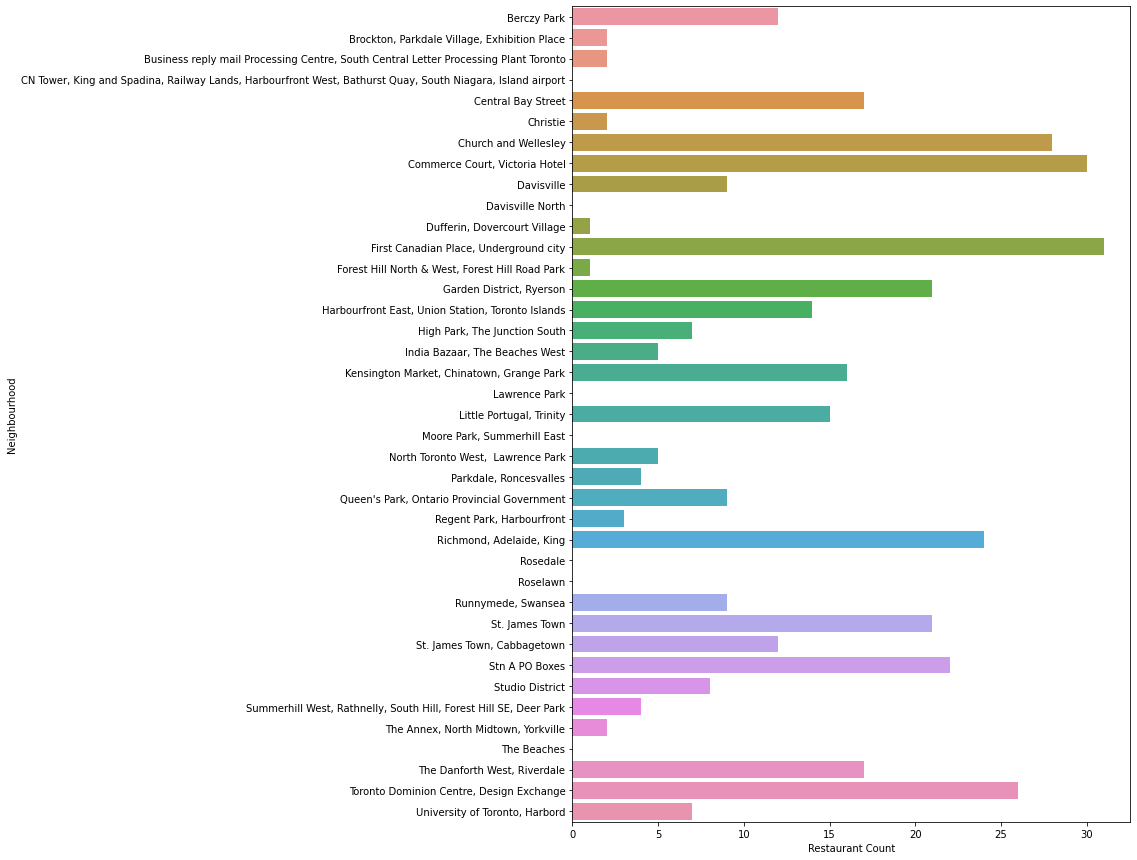

In [386]:
fig, ax = plt.subplots(figsize=(10,15))
sns.barplot(x="Restaurant Count", y="Neighbourhood", data=nb_total, ax=ax)

From the bar plot above, the neighborhoods First Canadian Place and Underground City have the most restaurants. However, these are followed closely by the neighborhoods Commerce Court and Victoria Hotel, as well as Church and Wellesley.

In [387]:
city_grouped2 = city_onehot.groupby('Neighbourhood').mean().reset_index()
city_grouped2

,Neighbourhood,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.00,0.017241,0.00000,0.000000,0.000000,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00000,0.000000,0.000000,0.000000
2,"Business reply mail Processing Centre, South C...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00000,0.000000,0.000000,0.062500
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.066667,0.066667,0.066667,0.133333,0.066667,0.133333,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00000,0.000000,0.000000,0.000000
4,Central Bay Street,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.00,0.016667,0.00000,0.000000,0.016667,0.016667
5,Christie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00000,0.000000,0.000000,0.000000
6,Church and Wellesley,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012658,0.000000,0.00,...,0.012658,0.000000,0.000000,0.000000,0.00,0.000000,0.00000,0.012658,0.000000,0.025316
7,"Commerce Court, Victoria Hotel",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.00,0.020000,0.00000,0.000000,0.010000,0.000000
8,Davisville,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.030303,0.000000,0.00,0.000000,0.00000,0.000000,0.000000,0.000000
9,Davisville North,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.00000,0.000000,0.000000,0.000000


Another dataframe `res_grp` is then created by extracting columns containing the string 'Restaurant' from the `city_grouped2` dataframe and the 'Neighbourhood' column was inserted first into that dataframe. This will be used in subsequent clustering analysis using the *k*-means algorithm.

In [388]:
res_grp = city_grouped2.loc[:,city_grouped1.columns.str.contains("Restaurant")]

In [389]:
res_grp.insert(loc=0, column='Neighbourhood', value=cols)

In [390]:
res_grp.head()

,Neighbourhood,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,...,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,Berczy Park,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017241,...,0.000000,0.034483,0.034483,0.017241,0.0,0.017241,0.0,0.0,0.017241,0.0
1,"Brockton, Parkdale Village, Exhibition Place",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.045455,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
2,"Business reply mail Processing Centre, South C...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.062500,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
4,Central Bay Street,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.016667,0.000000,0.016667,0.016667,0.0,0.033333,0.0,0.0,0.016667,0.0


In [392]:
res_clustering = res_grp.drop('Neighbourhood', 1)

An initial clustering with 5 clusters was attempted

In [422]:
kclusters_res = 5
kmeans_res = KMeans(n_clusters=kclusters_res, random_state=42).fit(res_clustering)

The elbow method was used to try to find the optimum number of clusters for the algorithm. The point where the summed standard error curve starts to bend is known as the elbow point. This point is thought to be a reasonable trade-off between error generated and the number of clusters.

In [394]:
Sum_of_squared_distances = []
K = range(1,21)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(res_clustering)
    Sum_of_squared_distances.append(km.inertia_)

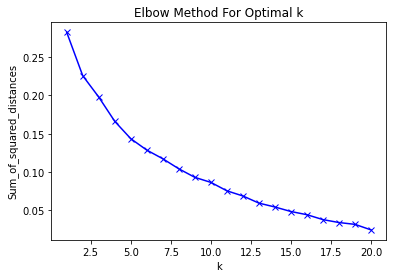

In [395]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

It was not clear where the elbow point is from the plot above. Therefore the `Kneelocator` method from the **kneed library** was used to identify the optimal k.

In [424]:
kl = KneeLocator(range(1, 21), Sum_of_squared_distances, curve="convex", direction="decreasing")

In [425]:
print(kl.elbow)

6


Additionally the optimal number of iterations can be obtained using the `n_iter_n` method.

In [423]:
kmeans_res.n_iter_

4

Based on the information above, the following code cell generates the kmeans labels required for the data.

In [426]:
kclusters_res = 6
kmeans_res = KMeans(n_clusters=kclusters_res, max_iter = 4, random_state=42).fit(res_clustering)

The `res2` dataframe contains the information on the neighborhoods, their cluster labels and their coordinates (latitude and longitude).

In [427]:
res2 = city_grouped2[['Neighbourhood']]
res2["Cluster Labels"] = kmeans_res.labels_
res2.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Neighbourhood,Cluster Labels
0,Berczy Park,1
1,"Brockton, Parkdale Village, Exhibition Place",1
2,"Business reply mail Processing Centre, South C...",5
3,"CN Tower, King and Spadina, Railway Lands, Har...",3
4,Central Bay Street,1


In [428]:
res2['Latitude'] = city_data['Latitude']
res2['Longitude'] = city_data['Longitude']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [429]:
res2.head()

,Neighbourhood,Cluster Labels,Latitude,Longitude
0,Berczy Park,1,43.676357,-79.293031
1,"Brockton, Parkdale Village, Exhibition Place",1,43.679557,-79.352188
2,"Business reply mail Processing Centre, South C...",5,43.668999,-79.315572
3,"CN Tower, King and Spadina, Railway Lands, Har...",3,43.659526,-79.340923
4,Central Bay Street,1,43.728020,-79.388790


The following code shows the top 10 venues in each neighbourhood, sorted in descending order:

In [430]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = res_grp['Neighbourhood']

for ind in np.arange(city_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(res_grp.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Seafood Restaurant,Restaurant,French Restaurant,Greek Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Japanese Restaurant,Comfort Food Restaurant,Eastern European Restaurant
1,"Brockton, Parkdale Village, Exhibition Place",Italian Restaurant,Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
2,"Business reply mail Processing Centre, South C...",Fast Food Restaurant,Restaurant,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Falafel Restaurant,Ethiopian Restaurant
3,"CN Tower, King and Spadina, Railway Lands, Har...",Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant
4,Central Bay Street,Italian Restaurant,Thai Restaurant,Portuguese Restaurant,Falafel Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Korean Restaurant,Middle Eastern Restaurant,Modern European Restaurant


In [431]:
print('The neighbourhoods_venues_sorted dataframe has', neighborhoods_venues_sorted.shape[0], 'rows and', neighborhoods_venues_sorted.shape[1], 'columns')

The neighbourhoods_venues_sorted dataframe has 39 rows and 11 columns


A new dataframe that includes the cluster value and the top 10 venues for each neighborhood is generated using the code cell below.

In [432]:
city_merged = res2
city_merged = city_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

city_merged.head() # check the last columns!

,Neighbourhood,Cluster Labels,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,1,43.676357,-79.293031,Seafood Restaurant,Restaurant,French Restaurant,Greek Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Japanese Restaurant,Comfort Food Restaurant,Eastern European Restaurant
1,"Brockton, Parkdale Village, Exhibition Place",1,43.679557,-79.352188,Italian Restaurant,Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
2,"Business reply mail Processing Centre, South C...",5,43.668999,-79.315572,Fast Food Restaurant,Restaurant,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Falafel Restaurant,Ethiopian Restaurant
3,"CN Tower, King and Spadina, Railway Lands, Har...",3,43.659526,-79.340923,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant
4,Central Bay Street,1,43.728020,-79.388790,Italian Restaurant,Thai Restaurant,Portuguese Restaurant,Falafel Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Korean Restaurant,Middle Eastern Restaurant,Modern European Restaurant


The clusters can then be visualized on the map as below:

In [433]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters_res)
ys = [i + x + (i*x)**2 for i in range(kclusters_res)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(city_merged['Latitude'], city_merged['Longitude'], city_merged['Neighbourhood'], city_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

---

## Part 4: Examining the clusters in selected boroughs in Toronto.

TO recap, the selected boroughs were Downtown Toronto, Central Toronto, East Toronto and West Toronto. Each cluster is then examined to determine the restaurant categories that distinguish each cluster. To faciliate analysis, the columns 'Latitude' and 'Longitude' was dropped from the dataframe (`city_merged`).

In [434]:
city_merged1 = city_merged[:]

In [435]:
city_merged1.drop(['Latitude', 'Longitude'], axis=1, inplace=True)
city_merged1.head()

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,1,Seafood Restaurant,Restaurant,French Restaurant,Greek Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Japanese Restaurant,Comfort Food Restaurant,Eastern European Restaurant
1,"Brockton, Parkdale Village, Exhibition Place",1,Italian Restaurant,Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
2,"Business reply mail Processing Centre, South C...",5,Fast Food Restaurant,Restaurant,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Falafel Restaurant,Ethiopian Restaurant
3,"CN Tower, King and Spadina, Railway Lands, Har...",3,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant
4,Central Bay Street,1,Italian Restaurant,Thai Restaurant,Portuguese Restaurant,Falafel Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Korean Restaurant,Middle Eastern Restaurant,Modern European Restaurant


To begin with, the number of neighborhoods for each cluster is shown by the code cell below. The results was assigned to the `cluster_df` dataframe and sorted.

In [436]:
cluster_df = pd.DataFrame(city_merged1['Cluster Labels'].value_counts())

In [437]:
cluster_df.columns = ['Neighborhood Count']

In [438]:
cluster_df.sort_index()

,Neighborhood Count
0,1
1,19
2,1
3,12
4,1
5,5


#### Cluster 1

Cluster 1 only has one neighborhood and the top restaurant type is a sushi restaurant. 

In [439]:
city_merged1.loc[city_merged1['Cluster Labels'] == 0]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,"Forest Hill North & West, Forest Hill Road Park",0,Sushi Restaurant,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant


#### Cluster 2

Cluster 2 has 19 neighborhoods and the top restaurant type is Vietnamese.

In [440]:
city_merged1.loc[city_merged1['Cluster Labels'] == 1]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,1,Seafood Restaurant,Restaurant,French Restaurant,Greek Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Sushi Restaurant,Japanese Restaurant,Comfort Food Restaurant,Eastern European Restaurant
1,"Brockton, Parkdale Village, Exhibition Place",1,Italian Restaurant,Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
4,Central Bay Street,1,Italian Restaurant,Thai Restaurant,Portuguese Restaurant,Falafel Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Korean Restaurant,Middle Eastern Restaurant,Modern European Restaurant
5,Christie,1,Italian Restaurant,Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
7,"Commerce Court, Victoria Hotel",1,Restaurant,American Restaurant,Seafood Restaurant,Japanese Restaurant,Italian Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,Gluten-free Restaurant,Latin American Restaurant,Asian Restaurant
8,Davisville,1,Italian Restaurant,Sushi Restaurant,Indian Restaurant,Restaurant,Seafood Restaurant,Greek Restaurant,Thai Restaurant,Brazilian Restaurant,Asian Restaurant,French Restaurant
11,"First Canadian Place, Underground city",1,Restaurant,Japanese Restaurant,American Restaurant,Asian Restaurant,Seafood Restaurant,Thai Restaurant,Sushi Restaurant,Mediterranean Restaurant,Brazilian Restaurant,Colombian Restaurant
14,"Harbourfront East, Union Station, Toronto Islands",1,Italian Restaurant,Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Sushi Restaurant,Seafood Restaurant,Chinese Restaurant,New American Restaurant,Mexican Restaurant
19,"Little Portugal, Trinity",1,Vietnamese Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,Restaurant,New American Restaurant,Cuban Restaurant,French Restaurant,Greek Restaurant,Japanese Restaurant,Korean Restaurant
21,"North Toronto West, Lawrence Park",1,Fast Food Restaurant,Seafood Restaurant,Restaurant,Chinese Restaurant,Mexican Restaurant,Vietnamese Restaurant,Doner Restaurant,German Restaurant,French Restaurant,Filipino Restaurant


#### Cluster 3

Cluster 3 has 1 neighborhood with a Thai restaurant as the top cuisine.

In [441]:
city_merged1.loc[city_merged1['Cluster Labels'] == 2]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,"High Park, The Junction South",2,Thai Restaurant,Mexican Restaurant,Italian Restaurant,Cajun / Creole Restaurant,Fast Food Restaurant,Doner Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Falafel Restaurant


#### Cluster 4

There is 12 neighborhoods in Cluster 4 and it has Vietnamese cuisine as the most common type.

In [442]:
city_merged1.loc[city_merged1['Cluster Labels'] == 3]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,"CN Tower, King and Spadina, Railway Lands, Har...",3,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant
9,Davisville North,3,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant
10,"Dufferin, Dovercourt Village",3,Middle Eastern Restaurant,Vietnamese Restaurant,Indian Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
13,"Garden District, Ryerson",3,Japanese Restaurant,Middle Eastern Restaurant,Italian Restaurant,Fast Food Restaurant,Ramen Restaurant,New American Restaurant,Chinese Restaurant,Ethiopian Restaurant,Mexican Restaurant,Modern European Restaurant
17,"Kensington Market, Chinatown, Grange Park",3,Vietnamese Restaurant,Vegetarian / Vegan Restaurant,Mexican Restaurant,Caribbean Restaurant,Comfort Food Restaurant,Japanese Restaurant,Filipino Restaurant,Doner Restaurant,Belgian Restaurant,Colombian Restaurant
18,Lawrence Park,3,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant
20,"Moore Park, Summerhill East",3,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant
24,"Regent Park, Harbourfront",3,Italian Restaurant,French Restaurant,Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
26,Rosedale,3,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant
27,Roselawn,3,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Eastern European Restaurant


#### Cluster 5

There is only one neighborhood in Cluster 5 and a Greek restaurant is the top common venue.

In [443]:
city_merged1.loc[city_merged1['Cluster Labels'] == 4]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
36,"The Danforth West, Riverdale",4,Greek Restaurant,Italian Restaurant,Restaurant,Caribbean Restaurant,Indian Restaurant,Japanese Restaurant,American Restaurant,Tibetan Restaurant,Seafood Restaurant,Cuban Restaurant


#### Cluster 6

There are five neighborhoods in Cluster 5 and the top most common venue is equally split between a sushi and fast food restaurant.

In [444]:
city_merged1.loc[city_merged1['Cluster Labels'] == 5]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,"Business reply mail Processing Centre, South C...",5,Fast Food Restaurant,Restaurant,Vietnamese Restaurant,Doner Restaurant,Gluten-free Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Falafel Restaurant,Ethiopian Restaurant
6,Church and Wellesley,5,Sushi Restaurant,Japanese Restaurant,Fast Food Restaurant,Restaurant,Mediterranean Restaurant,Vietnamese Restaurant,Mexican Restaurant,Caribbean Restaurant,Ethiopian Restaurant,Indian Restaurant
16,"India Bazaar, The Beaches West",5,Fast Food Restaurant,Italian Restaurant,Sushi Restaurant,Restaurant,Cuban Restaurant,German Restaurant,French Restaurant,Filipino Restaurant,Falafel Restaurant,Ethiopian Restaurant
23,"Queen's Park, Ontario Provincial Government",5,Sushi Restaurant,Italian Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant,Fast Food Restaurant,Restaurant,Portuguese Restaurant,Mexican Restaurant,Doner Restaurant,Filipino Restaurant
33,"Summerhill West, Rathnelly, South Hill, Forest...",5,Vietnamese Restaurant,Sushi Restaurant,Restaurant,American Restaurant,Thai Restaurant,Cuban Restaurant,French Restaurant,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant
